In [5]:
%run utils

In [6]:
from torch import nn
from utils import ConvRelu

class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3, ch5x5, pool_proj):
        super().__init__()
        self.branch1 = ConvRelu(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            ConvRelu(in_channels, ch3x3[0], kernel_size=1),
            ConvRelu(ch3x3[0], ch3x3[1], kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            ConvRelu(in_channels, ch5x5[0], kernel_size=1),
            ConvRelu(ch5x5[0], ch5x5[1], kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvRelu(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], 1)


inception = Inception(192, 64, (96, 128), (16, 32), 32)
print(inception)

Inception(
  (branch1): ConvRelu(
    (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
  )
  (branch2): Sequential(
    (0): ConvRelu(
      (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU()
    )
    (1): ConvRelu(
      (conv): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
  )
  (branch3): Sequential(
    (0): ConvRelu(
      (conv): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU()
    )
    (1): ConvRelu(
      (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (relu): ReLU()
    )
  )
  (branch4): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (1): ConvRelu(
      (conv): Conv2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU()
    )
  )
)


In [7]:
from utils import LinerRelu

class InceptionAux(nn.Module):
    def __init__(self, in_channels, dropout=0.5):
        super(InceptionAux, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.conv = nn.Sequential(
            ConvRelu(in_channels, 128, kernel_size=1),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            LinerRelu(128, 64, dropout=dropout),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv(x)
        x = self.fc(x)
        return x

aux = InceptionAux(512)
print(aux)

InceptionAux(
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (conv): Sequential(
    (0): ConvRelu(
      (conv): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU()
    )
    (1): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): LinerRelu(
      (lin): Linear(in_features=128, out_features=64, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [8]:
class GoogLeNet(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.b1 = nn.Sequential(
            ConvRelu(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.b2 = nn.Sequential(
            ConvRelu(64, 64, kernel_size=1),
            ConvRelu(64, 192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.b3 = nn.Sequential(
            Inception(192, 64, (96, 128), (16, 32), 32),
            Inception(256, 128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.b4a = Inception(480, 192, (96, 208), (16, 48), 64)
        self.aux1 = InceptionAux(512, dropout=dropout)
        self.b4bcd = nn.Sequential(
            Inception(512, 160, (112, 224), (24, 64), 64),
            Inception(512, 128, (128, 256), (24, 64), 64),
            Inception(512, 112, (144, 288), (32, 64), 64),
        )
        self.aux2 = InceptionAux(528, dropout=dropout)
        self.b4e = nn.Sequential(
            Inception(528, 256, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.b5 = nn.Sequential(
            Inception(832, 256, (160, 320), (32, 128), 128),
            Inception(832, 384, (192, 384), (48, 128), 128),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4a(x)
        aux1 = self.aux1(x)
        x = self.b4bcd(x)
        aux2 = self.aux2(x)
        x = self.b4e(x)
        x = self.b5(x)
        x = self.fc(x)
        return x, aux1, aux2

In [9]:
from torchinfo import summary
summary(GoogLeNet(), (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 8, 8]             --
│    └─ConvRelu: 2-1                     [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-1                  [1, 64, 16, 16]           9,472
│    │    └─ReLU: 3-2                    [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-2                    [1, 64, 8, 8]             --
├─Sequential: 1-2                        [1, 192, 4, 4]            --
│    └─ConvRelu: 2-3                     [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-3                  [1, 64, 8, 8]             4,160
│    │    └─ReLU: 3-4                    [1, 64, 8, 8]             --
│    └─ConvRelu: 2-4                     [1, 192, 8, 8]            --
│    │    └─Conv2d: 3-5                  [1, 192, 8, 8]            110,784
│    │    └─ReLU: 3-6                    [1, 192, 8, 8]            --
│   

In [10]:
from torchvision import datasets
from utils import train_val_split
from utils import PackDataset
from torchvision import transforms

full = datasets.CIFAR10(root="./data", train=True, download=True)
test = datasets.CIFAR10(root="./data", train=False, download=True)
train, valid = train_val_split(full, seed=666)

train_data = PackDataset(train, transform=transforms.ToTensor())
valid_data = PackDataset(valid, transform=transforms.ToTensor())
test_data = PackDataset(test, transform=transforms.ToTensor())

In [11]:
class LossWithAux(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        main_pred, aux1_pred, aux2_pred = pred
        main_loss = nn.functional.cross_entropy(main_pred, target)
        aux1_loss = nn.functional.cross_entropy(aux1_pred, target)
        aux2_loss = nn.functional.cross_entropy(aux2_pred, target)
        return main_loss + 0.3 * aux1_loss + 0.3 * aux2_loss

In [12]:
import json
from utils import control_callbacks
from sklearn.model_selection import ParameterGrid
import torch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

In [ ]:
epochs = 20
param_grid = {
    'lr': [0.005, 0.001, 0.0005, 0.0001],
    'dropout': [0.5, 0.3, 0.2]
}

results = {
    'best_params': None,
    'best_acc': 0.0,
    'all_results': []
}

calls = control_callbacks(epochs, check_dir='./data/alex-checkpoints', show_bar=False)
for params in ParameterGrid(param_grid):
    print(f"\nTraining with params: {params}")
    vgg = GoogLeNet(params['dropout'])
    net = NeuralNetClassifier(
        vgg,
        criterion=LossWithAux,
        optimizer=torch.optim.Adam,
        lr=params['lr'],
        batch_size=2048,
        max_epochs=epochs,
        train_split=predefined_split(valid_data),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        callbacks=calls,
        classes=list(range(10)),
    )
    net.fit(X=train_data, y=None)
    valid_acc = max(net.history[:, 'valid_acc'])
    current_result = {'params': params, 'valid_acc': valid_acc}
    results['all_results'].append(current_result)

    if valid_acc > results['best_acc']:
        results['best_acc'] = valid_acc
        results['best_params'] = params

    print(f"\nBest params: {results['best_params']}, best acc: {results['best_acc']}")

with open('./data/hyperparam_results.json', 'w') as f:
    json.dump(results, f, indent=2)

In [18]:
from utils import trans_aug

epochs = 100
gnet = GoogLeNet(0.2)
calls = control_callbacks(epochs, check_dir='./data/alex-checkpoints', show_bar=False)
full_data = PackDataset(full, transform=trans_aug())
net = NeuralNetClassifier(
    gnet,
    criterion=LossWithAux,
    optimizer=torch.optim.Adam,
    lr=0.001,
    optimizer__weight_decay=5e-4,
    batch_size=2048,
    max_epochs=epochs,
    train_split=predefined_split(test_data),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    callbacks=calls,
    classes=list(range(10)),
    iterator_train__num_workers=8,
    iterator_train__pin_memory=True,
)
net.fit(full_data, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  -----------  ------------  -----------  ------------  ----  ------  -------
      1       0.1106        3.6872       0.1063        3.6768     +  0.0010  15.1315
      2       0.1466        3.5748       0.1702        3.4310     +  0.0010  15.7135
      3       0.1787        3.3763       0.1940        3.2860     +  0.0010  15.2891
      4       0.2039        3.2462       0.2384        3.0762     +  0.0010  15.3491
      5       0.2233        3.1728       0.2472        3.1542     +  0.0010  15.5653
      6       0.2502        3.0754       0.2269        3.1291        0.0010  15.0735
      7       0.2680        2.9754       0.2698        2.9648     +  0.0010  15.2045
      8       0.2757        2.9912       0.3353        2.7540     +  0.0010  15.1182
      9       0.3156        2.8221       0.3285        2.7372        0.0010  15.5293
     10       0.2971        2.8849       0.3444        2.7686    

,module,"GoogLeNet( ..., bias=True) )"
,criterion,<class '__main__.LossWithAux'>
,train_split,functools.par...7fa465446bc0>)
,classes,"[0, 1, ...]"
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.001
,max_epochs,100
,batch_size,2048
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>


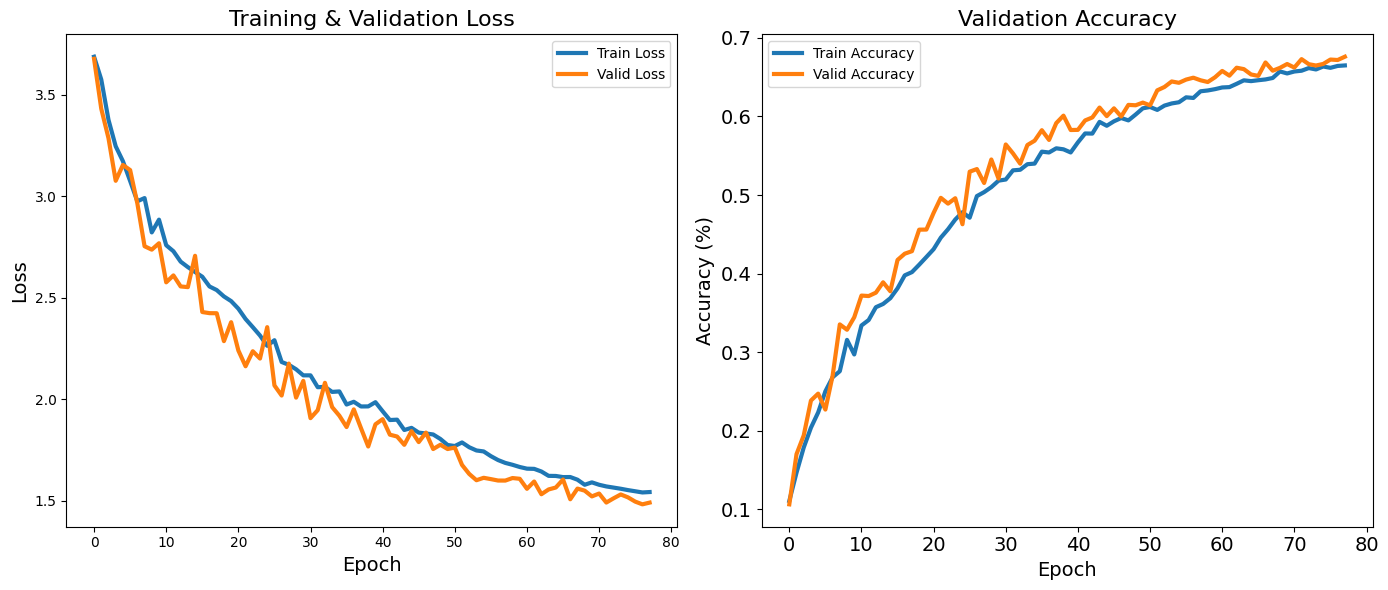

In [19]:
from utils import plot_history, check_result

plot_history(net)

Test Accuracy: 0.6760
Confusion Matrix:
 [[804  17  52   3  11   0  12   7  70  24]
 [ 25 798   0   4   2   0  16   2  31 122]
 [108   3 522  53 105  39 106  38  12  14]
 [ 27  16  95 361  81 151 153  55  25  36]
 [ 53   3  70  19 593  16 134  95   9   8]
 [ 18   4  60 188  64 488  55  90   9  24]
 [ 12  10  27  36  38   3 857   3   5   9]
 [ 47   0  17  25  74  27  18 762   1  29]
 [103  30   9  13   1   1   7   1 811  24]
 [ 66 103   3  10   0   2  18  14  20 764]]


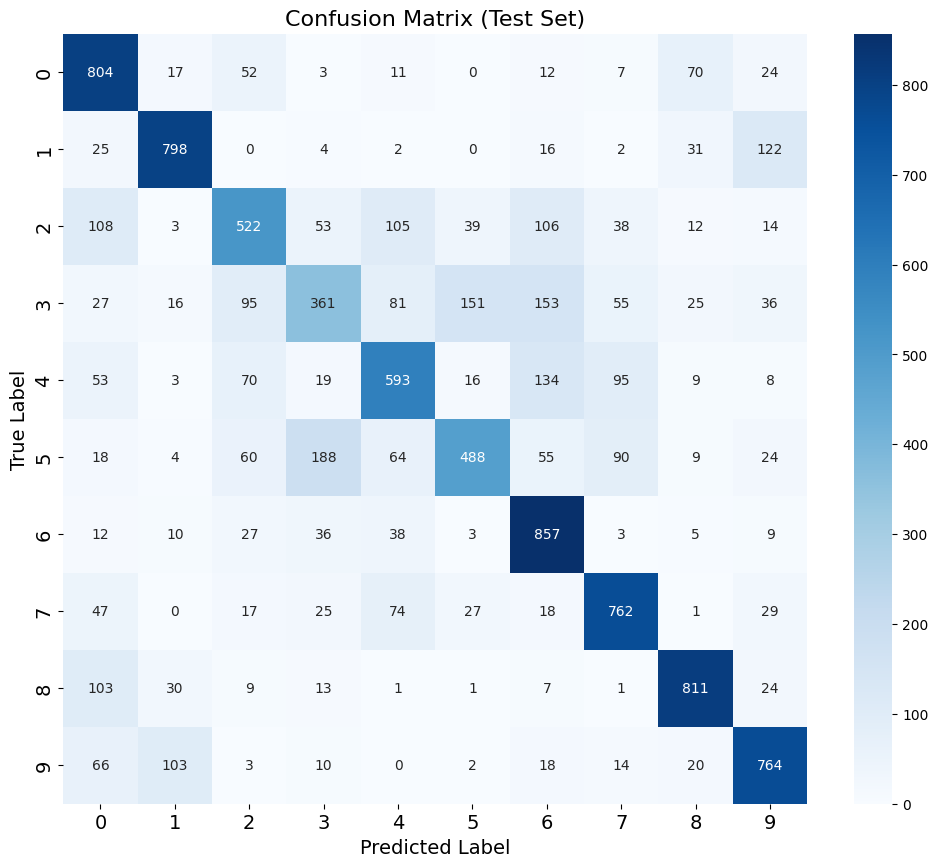

error number: 3240


[{'features': tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
           [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
           [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
           ...,
           [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
           [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
           [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],
  
          [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
           [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
           [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
           ...,
           [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
           [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
           [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],
  
          [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
           [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
          

In [21]:
check_result(net, test_data)

In [14]:
print("CIFAR-10 Classes:")
classes = {}
for i, class_name in enumerate(full.classes):
    classes[i] = class_name
print(f"{classes}")

CIFAR-10 Classes:
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


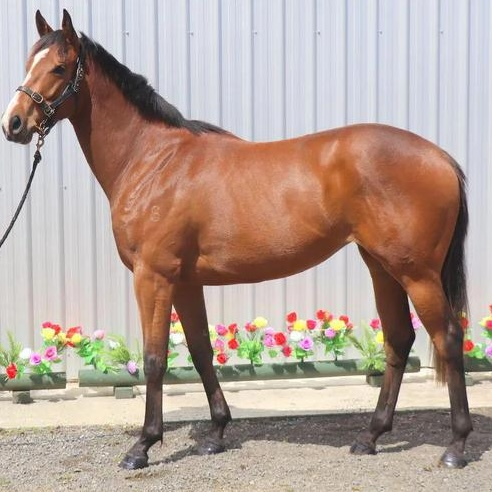

In [15]:
from PIL import Image
from IPython.display import display

img_src = Image.open('./data/dome1.jpeg')
display(img_src)

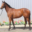

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])


In [16]:
from utils import show_tensor_image

test_transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
img = test_transform(img_src)
show_tensor_image(img)
print(img.shape)
img = img.unsqueeze(0)
print(img.shape)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('./data/checkpoints/best_model.pt', map_location=device)
load_model = GoogLeNet(0.2)
load_model.to(device)
load_model.load_state_dict(checkpoint)

with torch.no_grad():
    img = img.to(device)
    pred = load_model(img)
    print(pred)
    pred = pred[0].argmax(dim=1)
    print("类别是: ",  classes[pred.item()])

(tensor([[ -3.0554,  -8.1221,  -1.1850,  -0.8646,   4.7222,   2.7821,  -8.0887,
          13.5304, -13.4801,  -1.3815]]), tensor([[ -2.3288,  -8.4902,  -1.9107,  -2.4446,   5.7889,   1.4495,  -9.4913,
          11.8014, -12.7584,  -1.4946]]), tensor([[ -3.8457, -10.4307,  -2.9310,  -0.7527,   4.6392,   2.5045,  -9.5670,
          12.7430, -10.1874,   0.5584]]))
类别是:  horse
